In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.cuda.is_available()) # True
print(torch.cuda.device_count()) # 1
print(torch.cuda.current_device()) # 0
print(torch.cuda.device(0)) # <torch.cuda.device at 0x7efce0b03be0>
print(torch.cuda.get_device_name(0)) # 'GeForce GTX 950M'

True
2
0
NVIDIA TITAN Xp


In [3]:
import sys
sys.path.append("../../..")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-12-14 14:07:59.309135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 14:08:00.840455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 14:08:00.840589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 14:08:00.840605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [6]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [7]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
# loader.print_readme()

In [8]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [9]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [10]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Aplicar FFT

In [11]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [12]:
train_dataset_fft = transformer(train_val)
test_dataset_fft = transformer(test)

In [13]:
print(train_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(4020, 180)
(1020, 180)


In [14]:
print(np.max(train_dataset_fft.X))

797.3368276806895


In [15]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [16]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 180) (4020,) (1020, 180) (1020,)


# Visualization helper

In [17]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## Reading model

In [18]:
# Variables to reuse
save_id = 0
model_name = 'ConvolutionalAutoencoder_custom_dim3'
model_dim = 10
model_epc = 10
model_lam = 0

In [19]:
filename = 'data/{}_{}_{}_{}_{}.pkl'.format(model_name, model_lam, model_dim, model_epc, save_id)

In [29]:
filename = 'data/ConvolutionalAutoencoder_custom_dim3_0.01_180-10_25_0.pkl'

In [30]:
import pickle
filehandler = open(filename, 'rb')
model_reducer = pickle.load(filehandler)
filehandler.close()

In [22]:
train_LD = model_reducer.transform(train_HD)
test_LD = model_reducer.transform(test_HD)

In [23]:
train_LD = np.reshape(model_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(model_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [24]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


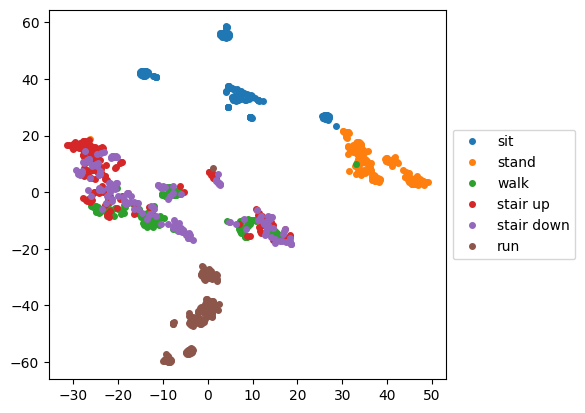

In [25]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [28]:
model_reducer.current

{'epoch': 5,
 'train_recon_error': 391.6557171161358,
 'train_topo_error': 1031.992182804988,
 'train_error': 401.9756422776442,
 'val_recon_error': 371.78332083565846,
 'val_topo_error': 1045.2193167550224,
 'val_error': 382.23551286969865,
 'last_error': None}

In [31]:
model_reducer.current

{'epoch': 25,
 'train_recon_error': 95.48260586078351,
 'train_topo_error': 706.3656264085037,
 'train_error': 102.54626230093149,
 'val_recon_error': 98.64812469482422,
 'val_topo_error': 682.0014953613281,
 'val_error': 105.4681396484375,
 'last_error': None}